In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import gensim
from gensim.models import Word2Vec
import sklearn
from sklearn.model_selection import train_test_split
from gensim import downloader
from tqdm import tqdm
import random

In [3]:
nyt_df = pd.read_csv('/content/drive/MyDrive/NLP/Project/nytcrosswords.csv',parse_dates = ['Date'],encoding='ISO-8859-1')

In [4]:
nyt_df

,Date,Word,Clue
0,2021-10-31,PAT,"Action done while saying ""Good dog"""
1,2021-10-31,RASCALS,Mischief-makers
2,2021-10-31,PEN,It might click for a writer
3,2021-10-31,SEP,Fall mo.
4,2021-10-31,ECO,Kind to Mother Nature
...,...,...,...
781568,1993-11-21,NAT,Actor Pendleton
781569,1993-11-21,SHRED,Bit
781570,1993-11-21,NEA,Teachers' org.
781571,1993-11-21,BEG,Petition


In [5]:
nyt_df['day_of_week'] = nyt_df['Date'].apply(lambda x: x.day_name())

In [6]:
nyt_df

,Date,Word,Clue,day_of_week
0,2021-10-31,PAT,"Action done while saying ""Good dog""",Sunday
1,2021-10-31,RASCALS,Mischief-makers,Sunday
2,2021-10-31,PEN,It might click for a writer,Sunday
3,2021-10-31,SEP,Fall mo.,Sunday
4,2021-10-31,ECO,Kind to Mother Nature,Sunday
...,...,...,...,...
781568,1993-11-21,NAT,Actor Pendleton,Sunday
781569,1993-11-21,SHRED,Bit,Sunday
781570,1993-11-21,NEA,Teachers' org.,Sunday
781571,1993-11-21,BEG,Petition,Sunday


# Statistics about days of week

The Saturday crossword is actually the hardest puzzle of the week. Mondays have the most straightforward clues and Saturday clues are the hardest, or involve the most wordplay. Contrary to popular belief, the Sunday puzzles are midweek difficulty, not the hardest. They’re just bigger.
[Article about the difficulty](https://www.nytimes.com/guides/crosswords/how-to-solve-a-crossword-puzzle)

In [7]:
days_week_dict = {d:nyt_df[nyt_df['day_of_week'].apply(lambda x: x == d)].shape[0] for d in set(nyt_df['day_of_week'])}

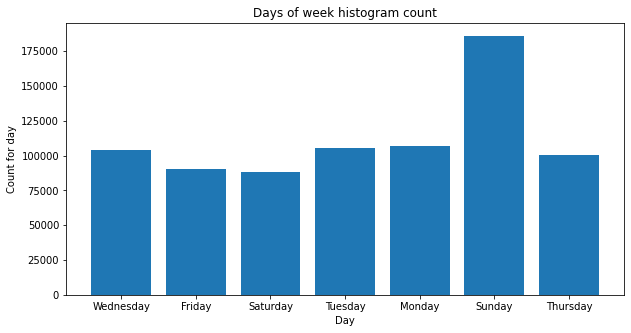

In [8]:
plt.figure(figsize = (10,5))
plt.bar([i for i in range(len(days_week_dict.keys()))],days_week_dict.values())
plt.title('Days of week histogram count')
plt.ylabel('Count for day')
plt.xlabel('Day')
plt.xticks([i for i in range(len(days_week_dict.keys()))],list(days_week_dict.keys()))
plt.show()

In [9]:
np.sum([v for v in days_week_dict.values()])

781573

In [10]:
days = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
total = np.sum([v for v in days_week_dict.values()])
for d in days:
  print(d,' Values is ',days_week_dict[d],' Which in proportion to other days is: ',round(days_week_dict[d]/total,3))

Sunday  Values is  185922  Which in proportion to other days is:  0.238
Monday  Values is  106971  Which in proportion to other days is:  0.137
Tuesday  Values is  105562  Which in proportion to other days is:  0.135
Wednesday  Values is  103910  Which in proportion to other days is:  0.133
Thursday  Values is  100480  Which in proportion to other days is:  0.129
Friday  Values is  90534  Which in proportion to other days is:  0.116
Saturday  Values is  88194  Which in proportion to other days is:  0.113


**Lets check the years range and simple statistics**

In [11]:
nyt_df['year'] = nyt_df['Date'].apply(lambda x: x.year)

In [12]:
nyt_df

,Date,Word,Clue,day_of_week,year
0,2021-10-31,PAT,"Action done while saying ""Good dog""",Sunday,2021
1,2021-10-31,RASCALS,Mischief-makers,Sunday,2021
2,2021-10-31,PEN,It might click for a writer,Sunday,2021
3,2021-10-31,SEP,Fall mo.,Sunday,2021
4,2021-10-31,ECO,Kind to Mother Nature,Sunday,2021
...,...,...,...,...,...
781568,1993-11-21,NAT,Actor Pendleton,Sunday,1993
781569,1993-11-21,SHRED,Bit,Sunday,1993
781570,1993-11-21,NEA,Teachers' org.,Sunday,1993
781571,1993-11-21,BEG,Petition,Sunday,1993


In [13]:
years_dict = {}
years = set([date.year for date in list(nyt_df['Date'])])
years_dict = {year: nyt_df[nyt_df['year'] == year].shape[0] for year in years}

In [14]:
years_dict

{1993: 3246,
 1994: 27991,
 1995: 27943,
 1996: 27882,
 1997: 27958,
 1998: 28104,
 1999: 28248,
 2000: 28104,
 2001: 27885,
 2002: 27984,
 2003: 28107,
 2004: 28016,
 2005: 27784,
 2006: 28011,
 2007: 27904,
 2008: 28069,
 2009: 28037,
 2010: 27929,
 2011: 27930,
 2012: 27939,
 2013: 27823,
 2014: 27987,
 2015: 27875,
 2016: 27949,
 2017: 27925,
 2018: 27633,
 2019: 27826,
 2020: 28064,
 2021: 23420}

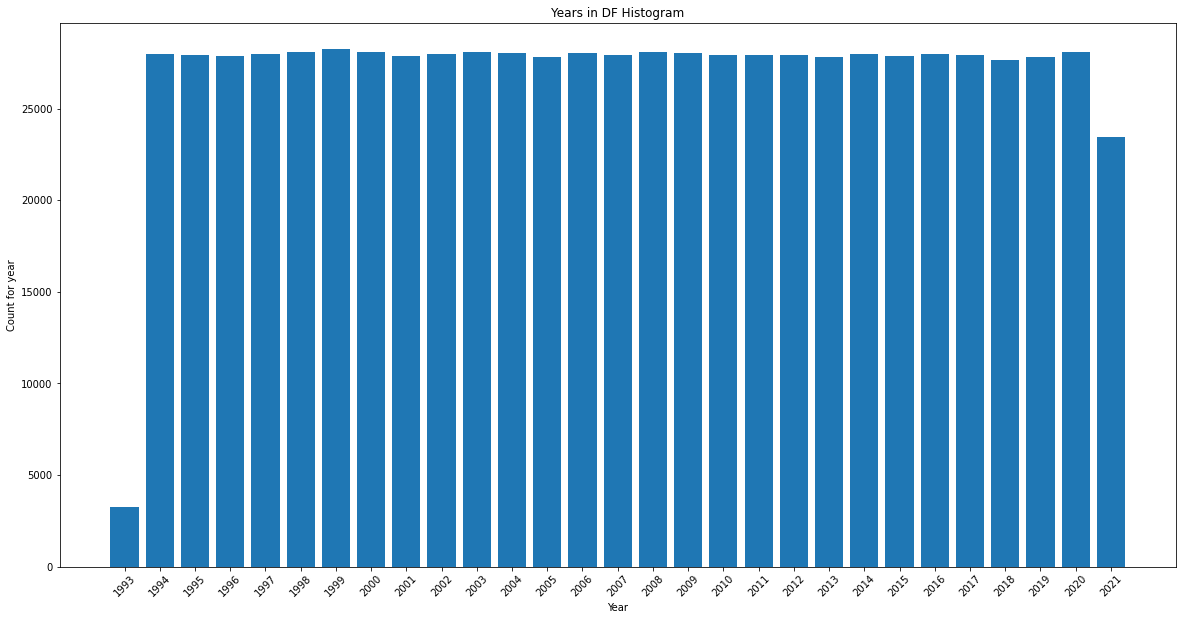

In [15]:
plt.figure(figsize = (20,10))
plt.bar([i for i in range(len(years_dict.keys()))],years_dict.values())
plt.title('Years in DF Histogram')
plt.ylabel('Count for year')
plt.xlabel('Year')
plt.xticks([i for i in range(len(years_dict.keys()))],list(years_dict.keys()),rotation = 45)
plt.show()

**We need to randomly split the sundays so there are as common as others**

We need to drop randomly about 10k Sundays entries , or about half of the Sunday enteries

In [16]:
nyt_df[nyt_df['day_of_week'] == 'Sunday'].shape[0] - round(nyt_df[nyt_df['day_of_week'] == 'Sunday'].shape[0]*0.45,0)

102257.0

In [17]:
round(nyt_df[nyt_df['day_of_week'] == 'Sunday'].shape[0]*0.45,0)

83665.0

Lets drop say 45% of Sunday enteries , this this is about : 83664 enteries

In [18]:
sundays_index_list = np.array(nyt_df[nyt_df['day_of_week'] == 'Sunday'].index)

In [19]:
type(sundays_index_list)

numpy.ndarray

In [28]:
sundays_ids_to_drop = np.array(random.sample(set(sundays_index_list), 83664))
sundays_ids_to_drop.shape

(83664,)

In [29]:
sundays_ids_to_drop

array([703280, 124054, 636063, ..., 164791, 343044, 302760])

In [30]:
print('Lets check that after dup drop still has 83664 indexs to drop',len(set(sundays_ids_to_drop)))

Lets check that after dup drop still has 83664 indexs to drop 83664


In [31]:
print('len of sundays ids to drop is ',len(sundays_ids_to_drop))

len of sundays ids to drop is  83664


In [32]:
print('Total DF size before is',nyt_df.shape,'. Sundays enteries count is ',nyt_df[nyt_df['day_of_week'] == 'Sunday'].shape)

Total DF size before is (781573, 5) . Sundays enteries count is  (185922, 5)


In [33]:
print('After we drop the enteries we should be left with',nyt_df[nyt_df['day_of_week'] == 'Sunday'].shape[0] - sundays_ids_to_drop.shape[0])

After we drop the enteries we should be left with 102258


In [34]:
nyt_df.drop(index=sundays_ids_to_drop, inplace=True)

In [35]:
print('Total DF size after is',nyt_df.shape,'. Sundays enteries count is ',nyt_df[nyt_df['day_of_week'] == 'Sunday'].shape)

Total DF size after is (697909, 5) . Sundays enteries count is  (102258, 5)


Lets plot Days histogram once again

In [36]:
days_week_dict_balanced = {d:nyt_df[nyt_df['day_of_week'].apply(lambda x: x == d)].shape[0] for d in set(nyt_df['day_of_week'])}

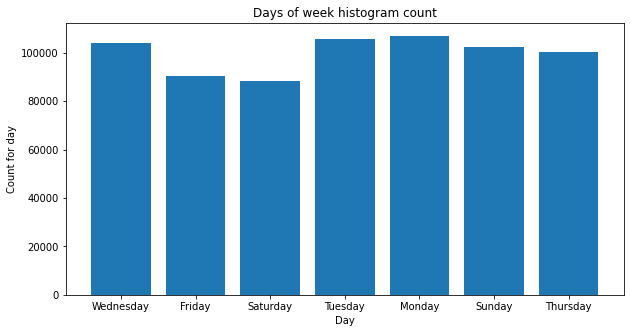

In [37]:
plt.figure(figsize = (10,5))
plt.bar([i for i in range(len(days_week_dict_balanced.keys()))],days_week_dict_balanced.values())
plt.title('Days of week histogram count')
plt.ylabel('Count for day')
plt.xlabel('Day')
plt.xticks([i for i in range(len(days_week_dict_balanced.keys()))],list(days_week_dict_balanced.keys()))
plt.show()

# Lets continue to further explore the DS

In [ ]:
nyt_balanced_df = pd.read_csv('/content/drive/MyDrive/NLP/Project/nytcrosswords_balanced_days.csv',parse_dates = ['Date'],encoding='ISO-8859-1')
nyt_balanced_df

,Unnamed: 0,Date,Word,Clue,day_of_week,year
0,0,2021-10-31,PEN,It might click for a writer,Sunday,2021
1,1,2021-10-31,SEP,Fall mo.,Sunday,2021
2,2,2021-10-31,ECO,Kind to Mother Nature,Sunday,2021
3,3,2021-10-31,EMMYLOU,Harris in the Country Music Hall of Fame,Sunday,2021
4,4,2021-10-31,HITORMISS,Haphazard,Sunday,2021
...,...,...,...,...,...,...
689696,689696,1993-11-21,DOZE,Nap,Sunday,1993
689697,689697,1993-11-21,ACE,King's superior,Sunday,1993
689698,689698,1993-11-21,NAT,Actor Pendleton,Sunday,1993
689699,689699,1993-11-21,NEA,Teachers' org.,Sunday,1993


In [ ]:
nyt_balanced_df.drop(columns = ['Unnamed: 0'],inplace = True)
nyt_balanced_df

,Date,Word,Clue,day_of_week,year
0,2021-10-31,PEN,It might click for a writer,Sunday,2021
1,2021-10-31,SEP,Fall mo.,Sunday,2021
2,2021-10-31,ECO,Kind to Mother Nature,Sunday,2021
3,2021-10-31,EMMYLOU,Harris in the Country Music Hall of Fame,Sunday,2021
4,2021-10-31,HITORMISS,Haphazard,Sunday,2021
...,...,...,...,...,...
689696,1993-11-21,DOZE,Nap,Sunday,1993
689697,1993-11-21,ACE,King's superior,Sunday,1993
689698,1993-11-21,NAT,Actor Pendleton,Sunday,1993
689699,1993-11-21,NEA,Teachers' org.,Sunday,1993


In [ ]:
def generate_days_histogram(df):
  days_week_dict = {d:df[df['day_of_week'].apply(lambda x: x == d)].shape[0] for d in set(df['day_of_week'])}
  days = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
  total = np.sum([v for v in days_week_dict.values()])
  for d in days:
    print(d,' Values is ',days_week_dict[d],' Which in proportion to other days is: ',round(days_week_dict[d]/total,3))
  plt.figure(figsize = (10,5))
  plt.bar([i for i in range(len(days_week_dict.keys()))],days_week_dict.values())
  plt.title('Days of week histogram count')
  plt.ylabel('Count for day')
  plt.xlabel('Day')
  plt.xticks([i for i in range(len(days_week_dict.keys()))],list(days_week_dict.keys()))
  plt.show()

Sunday  Values is  101249  Which in proportion to other days is:  0.147
Monday  Values is  105913  Which in proportion to other days is:  0.154
Tuesday  Values is  104303  Which in proportion to other days is:  0.151
Wednesday  Values is  102496  Which in proportion to other days is:  0.149
Thursday  Values is  99119  Which in proportion to other days is:  0.144
Friday  Values is  89489  Which in proportion to other days is:  0.13
Saturday  Values is  87132  Which in proportion to other days is:  0.126


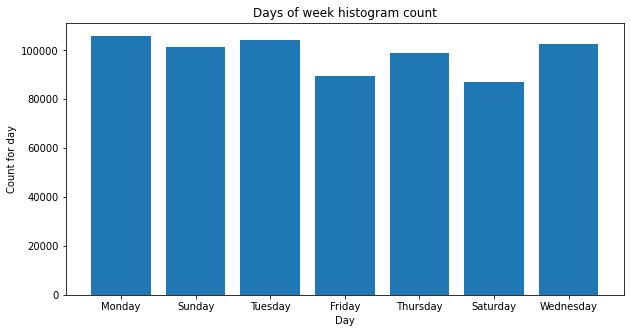

In [ ]:
generate_days_histogram(nyt_balanced_df)

In [ ]:
nyt_balanced_df[nyt_balanced_df['Clue'].apply(lambda x: '_' in str(x))]

,Date,Word,Clue,day_of_week,year
21,2021-10-31,ARTIE,"___ Kornfeld, music promoter for Woodstock",Sunday,2021
25,2021-10-31,SHE,"""Murder, ___ Wrote""",Sunday,2021
26,2021-10-31,SACHS,"Samuel ___, business partner of Marcus Goldman",Sunday,2021
33,2021-10-31,AMES,Silicon Valley's ___ Research Center,Sunday,2021
47,2021-10-31,DEUS,___ ex machina,Sunday,2021
...,...,...,...,...,...
689623,1993-11-22,ATALL,"""Any Time ___"" (Beatles tune)",Monday,1993
689664,1993-11-21,SIRENS,"Vonnegut's ""The ___ of Titan""",Sunday,1993
689685,1993-11-21,ENOLA,___ Gay,Sunday,1993
689690,1993-11-21,ORA,___ pro nobis,Sunday,1993


Sunday  Values is  7210  Which in proportion to other days is:  0.145
Monday  Values is  9737  Which in proportion to other days is:  0.195
Tuesday  Values is  8382  Which in proportion to other days is:  0.168
Wednesday  Values is  7226  Which in proportion to other days is:  0.145
Thursday  Values is  7248  Which in proportion to other days is:  0.145
Friday  Values is  5270  Which in proportion to other days is:  0.106
Saturday  Values is  4800  Which in proportion to other days is:  0.096


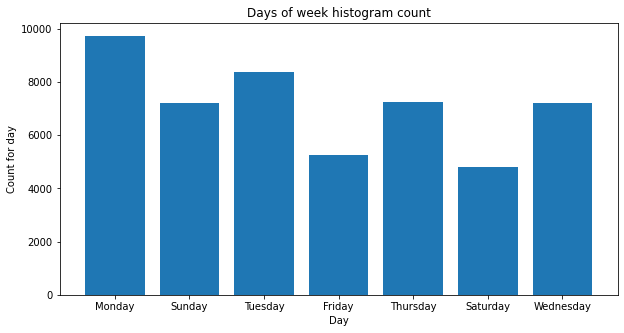

In [ ]:
generate_days_histogram(nyt_balanced_df[nyt_balanced_df['Clue'].apply(lambda x: '_' in str(x))])

In [ ]:
nyt_balanced_df[nyt_balanced_df['Clue'].apply(lambda x: '_' not in str(x))]

,Unnamed: 0,Date,Word,Clue,day_of_week,year
0,0,2021-10-31,PEN,It might click for a writer,Sunday,2021
1,1,2021-10-31,SEP,Fall mo.,Sunday,2021
2,2,2021-10-31,ECO,Kind to Mother Nature,Sunday,2021
3,3,2021-10-31,EMMYLOU,Harris in the Country Music Hall of Fame,Sunday,2021
4,4,2021-10-31,HITORMISS,Haphazard,Sunday,2021
...,...,...,...,...,...,...
689696,689696,1993-11-21,DOZE,Nap,Sunday,1993
689697,689697,1993-11-21,ACE,King's superior,Sunday,1993
689698,689698,1993-11-21,NAT,Actor Pendleton,Sunday,1993
689699,689699,1993-11-21,NEA,Teachers' org.,Sunday,1993


# Split DS to train eval and test

In [ ]:
def split_to_train_eval_test(df,train_size = 0.7 , eval_size = 0.2 , test_size = 0.1):
  full_index_list = np.array(df.index)
  size_of_train = int(full_index_list.shape[0]*train_size)
  train_index_list = np.array(random.sample(set(full_index_list),size_of_train))
  train_df = df.filter(items = train_index_list, axis=0)
  not_train_df = df.drop(train_index_list,axis = 0)
  
  left_indexs = np.array(not_train_df.index)
  eval_ration = round(eval_size / (eval_size + test_size),2)
  eval_size = int(eval_ration*left_indexs.shape[0])
  eval_index = np.array(random.sample(set(left_indexs),eval_size))

  eval_df = not_train_df.filter(items = eval_index, axis=0)
  test_df = not_train_df.drop(eval_index,axis = 0)
  return train_df , eval_df , test_df

In [ ]:
nyt_train_df , nyt_eval_df , nyt_test_df = split_to_train_eval_test(nyt_balanced_df)

In [ ]:
print('size of train nyt df is',nyt_train_df.shape,'\nSize of eval is ',nyt_eval_df.shape,'\nSize of test nyt df is ',nyt_test_df.shape)
print('Size of whole nyt balanced df is',nyt_balanced_df.shape,'\nthe split DF sum up to ',nyt_train_df.shape[0]+nyt_eval_df.shape[0] + nyt_test_df.shape[0])
print('Ratio for train ',nyt_train_df.shape[0]/nyt_balanced_df.shape[0],'\nration for eval is',nyt_eval_df.shape[0]/nyt_balanced_df.shape[0],'\nration for test is',nyt_test_df.shape[0]/nyt_balanced_df.shape[0])

size of train nyt df is (482790, 5) 
Size of eval is  (138630, 5) 
Size of test nyt df is  (68281, 5)
Size of whole nyt balanced df is (689701, 5) 
the split DF sum up to  689701
Ratio for train  0.6999989850674423 
ration for eval is 0.20100014354046172 
ration for test is 0.099000871392096


Sunday  Values is  70857  Which in proportion to other days is:  0.147
Monday  Values is  74293  Which in proportion to other days is:  0.154
Tuesday  Values is  72941  Which in proportion to other days is:  0.151
Wednesday  Values is  71703  Which in proportion to other days is:  0.149
Thursday  Values is  69413  Which in proportion to other days is:  0.144
Friday  Values is  62639  Which in proportion to other days is:  0.13
Saturday  Values is  60944  Which in proportion to other days is:  0.126


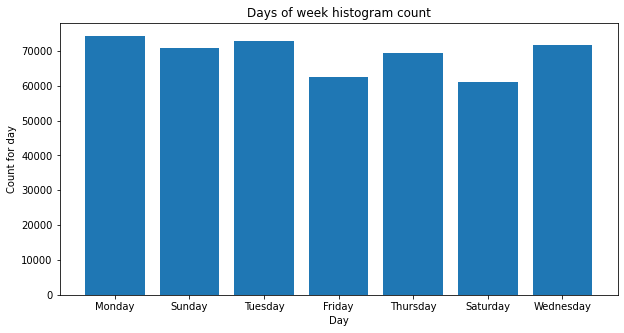

In [ ]:
generate_days_histogram(nyt_train_df)

Sunday  Values is  20375  Which in proportion to other days is:  0.147
Monday  Values is  21275  Which in proportion to other days is:  0.153
Tuesday  Values is  20976  Which in proportion to other days is:  0.151
Wednesday  Values is  20596  Which in proportion to other days is:  0.149
Thursday  Values is  19919  Which in proportion to other days is:  0.144
Friday  Values is  17998  Which in proportion to other days is:  0.13
Saturday  Values is  17491  Which in proportion to other days is:  0.126


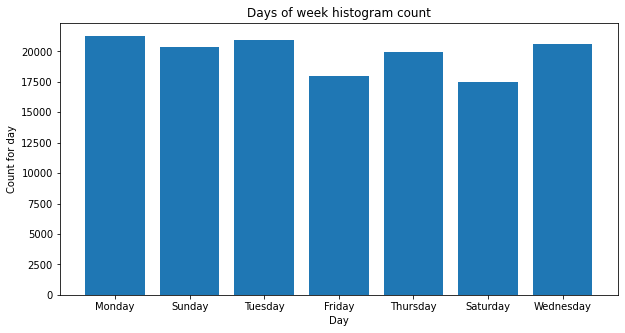

In [ ]:
generate_days_histogram(nyt_eval_df)

Sunday  Values is  10017  Which in proportion to other days is:  0.147
Monday  Values is  10345  Which in proportion to other days is:  0.152
Tuesday  Values is  10386  Which in proportion to other days is:  0.152
Wednesday  Values is  10197  Which in proportion to other days is:  0.149
Thursday  Values is  9787  Which in proportion to other days is:  0.143
Friday  Values is  8852  Which in proportion to other days is:  0.13
Saturday  Values is  8697  Which in proportion to other days is:  0.127


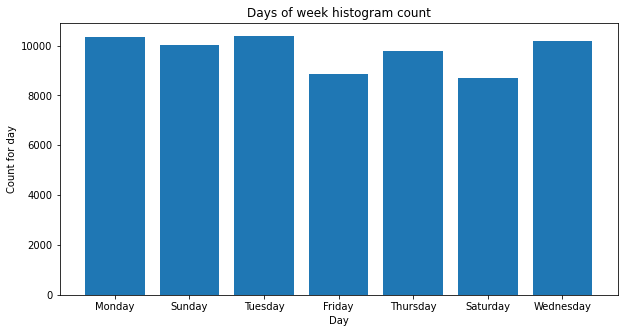

In [ ]:
generate_days_histogram(nyt_test_df)

**As we can see the split was successfull and the days ration is kept for futher complexity**

Lets save the models and import them to the BERT notebooks for fine tunning and predictions

In [ ]:
# nyt_train_df.to_csv('/content/drive/MyDrive/NLP/Project/nytcrosswords_balanced_days_train.csv')
# nyt_eval_df.to_csv('/content/drive/MyDrive/NLP/Project/nytcrosswords_balanced_days_eval.csv')
# nyt_test_df.to_csv('/content/drive/MyDrive/NLP/Project/nytcrosswords_balanced_days_test.csv')

# Lets shrink the DS abit because there are many enteries and the training time takes a while. 

We will drop indexes that are older than 2010 , and than check if we need to drop indexes from more recent years until we converge to about:
train - roughly 100k 
eval 30k-35k
test 14k-16k

In [57]:
def generate_days_histogram(df):
  days_week_dict = {d:df[df['day_of_week'].apply(lambda x: x == d)].shape[0] for d in set(df['day_of_week'])}
  days = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
  total = np.sum([v for v in days_week_dict.values()])
  for d in days:
    print(d,' Values is ',days_week_dict[d],' Which in proportion to other days is: ',round(days_week_dict[d]/total,3))
  plt.figure(figsize = (10,5))
  plt.bar([i for i in range(len(days_week_dict.keys()))],days_week_dict.values())
  plt.title('Days of week histogram count')
  plt.ylabel('Count for day')
  plt.xlabel('Day')
  plt.xticks([i for i in range(len(days_week_dict.keys()))],list(days_week_dict.keys()))
  plt.show()

In [ ]:
nyt_train_df = pd.read_csv('/content/drive/MyDrive/NLP/Project/nytcrosswords_balanced_days_train.csv')
nyt_eval_df = pd.read_csv('/content/drive/MyDrive/NLP/Project/nytcrosswords_balanced_days_eval.csv')
nyt_test_df = pd.read_csv('/content/drive/MyDrive/NLP/Project/nytcrosswords_balanced_days_test.csv')

In [ ]:
nyt_train_df.drop(columns = ['Unnamed: 0'],inplace = True)

In [ ]:
nyt_eval_df.drop(columns = ['Unnamed: 0'],inplace = True)

In [ ]:
nyt_test_df.drop(columns = ['Unnamed: 0'],inplace = True)

In [ ]:
nyt_train_df[nyt_train_df['year'] >= 2010]

,Date,Word,Clue,day_of_week,year
0,2016-08-20,DEW,Wet blanket?,Saturday,2016
7,2020-10-21,SHOP,Union workplace,Wednesday,2020
10,2015-01-28,AWET,Mad as ___ hen,Wednesday,2015
13,2011-08-15,COOPER,"""The Last of the Mohicans"" author",Monday,2011
18,2012-01-30,ISLES,Spots in the Caribbean,Monday,2012
...,...,...,...,...,...
482780,2020-12-22,OLD,Aged,Tuesday,2020
482781,2011-01-23,LBS,Dumbbell abbr.,Sunday,2011
482786,2017-03-05,ROADSIDEDINER,[Circled letters]-advertised establishment,Sunday,2017
482788,2019-11-20,ERA,Baseball stat that's better when it's lower,Wednesday,2019


Sunday  Values is  29840  Which in proportion to other days is:  0.147
Monday  Values is  31219  Which in proportion to other days is:  0.153
Tuesday  Values is  30627  Which in proportion to other days is:  0.15
Wednesday  Values is  30137  Which in proportion to other days is:  0.148
Thursday  Values is  29493  Which in proportion to other days is:  0.145
Friday  Values is  26430  Which in proportion to other days is:  0.13
Saturday  Values is  25765  Which in proportion to other days is:  0.127


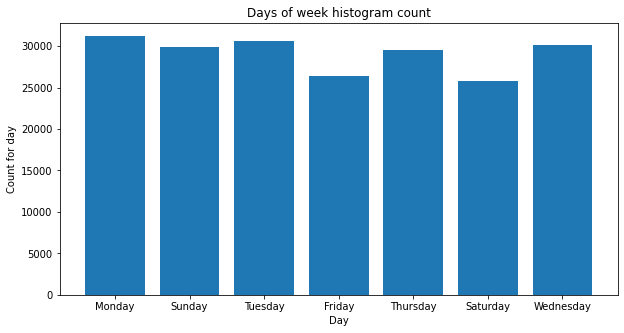

In [ ]:
generate_days_histogram(nyt_train_df[nyt_train_df['year'] >= 2010])

In [ ]:
nyt_eval_df[nyt_eval_df['year'] >= 2010]

,Date,Word,Clue,day_of_week,year
1,2015-09-07,INSPIRE,Motivate,Monday,2015
2,2017-10-29,ALONE,Stag,Sunday,2017
3,2020-08-11,EDGES,Things that spheres lack,Tuesday,2020
4,2018-12-17,TYKE,Young 'un,Monday,2018
8,2010-06-16,MARV,Sportscaster Albert,Wednesday,2010
...,...,...,...,...,...
138612,2017-10-12,ATEUP,Believed with no questions asked,Thursday,2017
138617,2011-08-29,SILT,Deposit around a river's mouth,Monday,2011
138618,2016-09-14,UTILITY,Gas or water,Wednesday,2016
138621,2020-10-17,CRI,"Shout, in Chamonix",Saturday,2020


Sunday  Values is  8550  Which in proportion to other days is:  0.146
Monday  Values is  8942  Which in proportion to other days is:  0.153
Tuesday  Values is  8888  Which in proportion to other days is:  0.152
Wednesday  Values is  8632  Which in proportion to other days is:  0.148
Thursday  Values is  8454  Which in proportion to other days is:  0.145
Friday  Values is  7605  Which in proportion to other days is:  0.13
Saturday  Values is  7310  Which in proportion to other days is:  0.125


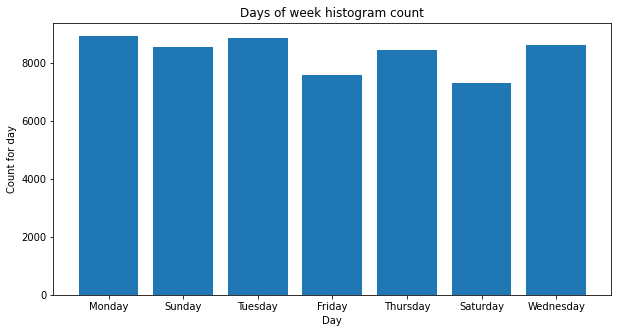

In [ ]:
generate_days_histogram(nyt_eval_df[nyt_eval_df['year'] >= 2010])

In [ ]:
nyt_test_df[nyt_test_df['year'] >= 2010]

,Date,Word,Clue,day_of_week,year
0,2021-10-31,SRO,Inits. for a theatrical hit,Sunday,2021
1,2021-10-31,STASIS,State of equilibrium,Sunday,2021
2,2021-10-31,SACHS,"Samuel ___, business partner of Marcus Goldman",Sunday,2021
3,2021-10-31,YES,"""You betcha!""",Sunday,2021
4,2021-10-31,TOETOTOE,Mano a mano,Sunday,2021
...,...,...,...,...,...
28725,2010-01-02,TYROS,Pros' opposites,Saturday,2010
28726,2010-01-01,LAZARUS,New Testament miracle recipient,Friday,2010
28727,2010-01-01,DUI,Police blotter abbr.,Friday,2010
28728,2010-01-01,OAK,One of Iowa's state symbols,Friday,2010


Sunday  Values is  4239  Which in proportion to other days is:  0.148
Monday  Values is  4367  Which in proportion to other days is:  0.152
Tuesday  Values is  4279  Which in proportion to other days is:  0.149
Wednesday  Values is  4237  Which in proportion to other days is:  0.147
Thursday  Values is  4223  Which in proportion to other days is:  0.147
Friday  Values is  3698  Which in proportion to other days is:  0.129
Saturday  Values is  3687  Which in proportion to other days is:  0.128


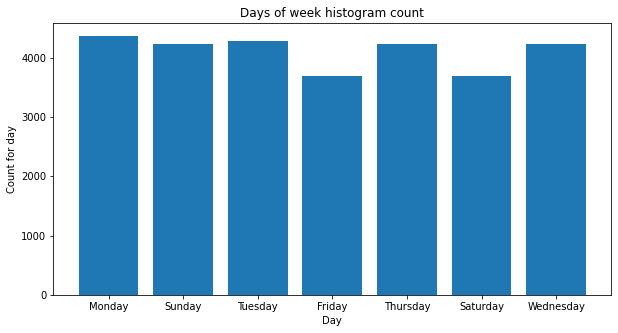

In [ ]:
generate_days_histogram(nyt_test_df[nyt_test_df['year'] >= 2010])

In [ ]:
nyt_train_df[nyt_train_df['year'] >= 2010].to_csv('/content/drive/MyDrive/NLP/Project/nytcrosswords_balanced_days_train_2010.csv')
nyt_eval_df[nyt_eval_df['year'] >= 2010].to_csv('/content/drive/MyDrive/NLP/Project/nytcrosswords_balanced_days_eval_2010.csv')
nyt_test_df[nyt_test_df['year'] >= 2010].to_csv('/content/drive/MyDrive/NLP/Project/nytcrosswords_balanced_days_test_2010.csv')

**Lets try and split by years see where this gets us in terms of size**

In [38]:
nyt_train_df_2010 = pd.read_csv('/content/drive/MyDrive/NLP/Project/nytcrosswords_balanced_days_train_2010.csv',parse_dates = ['Date'])
nyt_eval_df_2010 = pd.read_csv('/content/drive/MyDrive/NLP/Project/nytcrosswords_balanced_days_eval_2010.csv',parse_dates = ['Date'])
nyt_test_df_2010 = pd.read_csv('/content/drive/MyDrive/NLP/Project/nytcrosswords_balanced_days_test_2010.csv',parse_dates = ['Date'])

In [39]:
nyt_train_df_2010.drop(columns = ['Unnamed: 0'],inplace = True)
nyt_train_df_2010

,Date,Word,Clue,day_of_week,year
0,2016-08-20,DEW,Wet blanket?,Saturday,2016
1,2020-10-21,SHOP,Union workplace,Wednesday,2020
2,2015-01-28,AWET,Mad as ___ hen,Wednesday,2015
3,2011-08-15,COOPER,"""The Last of the Mohicans"" author",Monday,2011
4,2012-01-30,ISLES,Spots in the Caribbean,Monday,2012
...,...,...,...,...,...
203506,2020-12-22,OLD,Aged,Tuesday,2020
203507,2011-01-23,LBS,Dumbbell abbr.,Sunday,2011
203508,2017-03-05,ROADSIDEDINER,[Circled letters]-advertised establishment,Sunday,2017
203509,2019-11-20,ERA,Baseball stat that's better when it's lower,Wednesday,2019


In [40]:
nyt_eval_df_2010.drop(columns = ['Unnamed: 0'],inplace = True)
nyt_eval_df_2010

,Date,Word,Clue,day_of_week,year
0,2015-09-07,INSPIRE,Motivate,Monday,2015
1,2017-10-29,ALONE,Stag,Sunday,2017
2,2020-08-11,EDGES,Things that spheres lack,Tuesday,2020
3,2018-12-17,TYKE,Young 'un,Monday,2018
4,2010-06-16,MARV,Sportscaster Albert,Wednesday,2010
...,...,...,...,...,...
58376,2017-10-12,ATEUP,Believed with no questions asked,Thursday,2017
58377,2011-08-29,SILT,Deposit around a river's mouth,Monday,2011
58378,2016-09-14,UTILITY,Gas or water,Wednesday,2016
58379,2020-10-17,CRI,"Shout, in Chamonix",Saturday,2020


In [41]:
nyt_test_df_2010.drop(columns = ['Unnamed: 0'],inplace = True)
nyt_test_df_2010

,Date,Word,Clue,day_of_week,year
0,2021-10-31,SRO,Inits. for a theatrical hit,Sunday,2021
1,2021-10-31,STASIS,State of equilibrium,Sunday,2021
2,2021-10-31,SACHS,"Samuel ___, business partner of Marcus Goldman",Sunday,2021
3,2021-10-31,YES,"""You betcha!""",Sunday,2021
4,2021-10-31,TOETOTOE,Mano a mano,Sunday,2021
...,...,...,...,...,...
28725,2010-01-02,TYROS,Pros' opposites,Saturday,2010
28726,2010-01-01,LAZARUS,New Testament miracle recipient,Friday,2010
28727,2010-01-01,DUI,Police blotter abbr.,Friday,2010
28728,2010-01-01,OAK,One of Iowa's state symbols,Friday,2010


In [60]:
def create_year_histogram(df):
  years_dict = {}
  years = set([date.year for date in list(df['Date'])])
  years_dict = {year: df[df['year'] == year].shape[0] for year in years}
  years_dict = {k : years_dict[k] for k in sorted(years_dict)}
  plt.figure(figsize = (10,7))
  plt.bar([i for i in range(len(years_dict.keys()))],years_dict.values())
  plt.title('Years in DF Histogram')
  plt.ylabel('Count for year')
  plt.xlabel('Year')
  plt.xticks([i for i in range(len(years_dict.keys()))],list(years_dict.keys()),rotation = 45)
  plt.show()

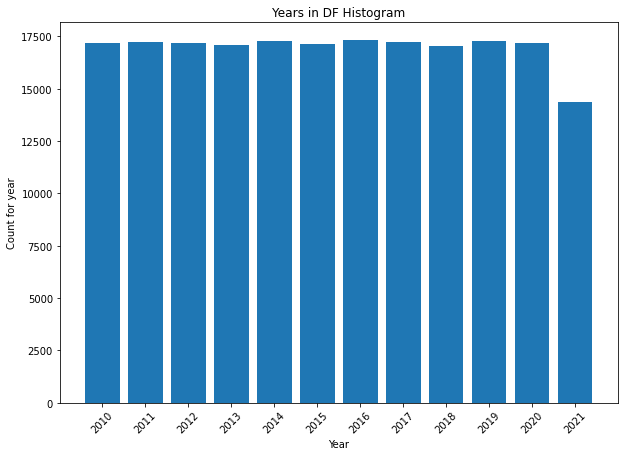

In [61]:
create_year_histogram(nyt_train_df_2010)

Sunday  Values is  29840  Which in proportion to other days is:  0.147
Monday  Values is  31219  Which in proportion to other days is:  0.153
Tuesday  Values is  30627  Which in proportion to other days is:  0.15
Wednesday  Values is  30137  Which in proportion to other days is:  0.148
Thursday  Values is  29493  Which in proportion to other days is:  0.145
Friday  Values is  26430  Which in proportion to other days is:  0.13
Saturday  Values is  25765  Which in proportion to other days is:  0.127


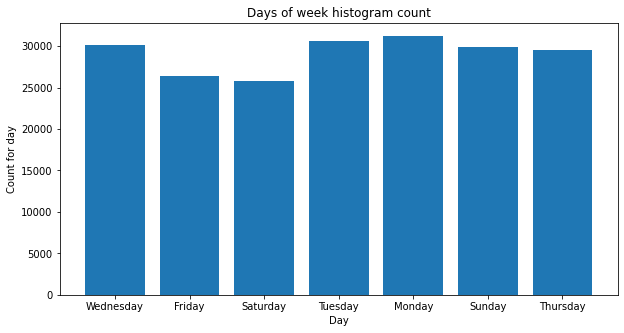

In [62]:
generate_days_histogram(nyt_train_df_2010)

Say we drop row with date earlier than year 2015

In [63]:
print('Total enteries for train df with 2015 and further crosswords',nyt_train_df_2010[nyt_train_df_2010['year'] >= 2015].shape)

Total enteries for train df with 2015 and further crosswords (117537, 5)


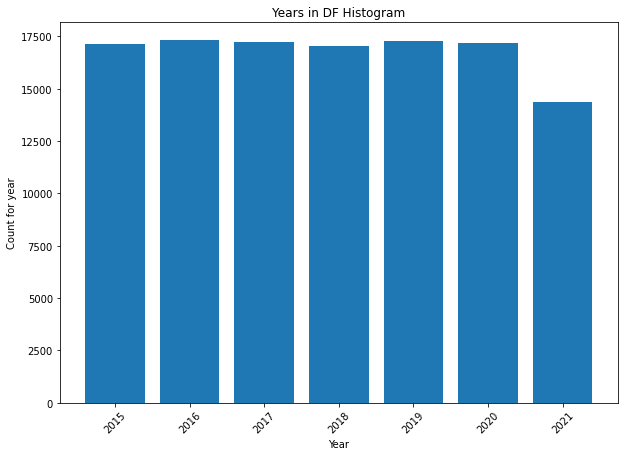

In [64]:
create_year_histogram(nyt_train_df_2010[nyt_train_df_2010['year'] >= 2015])

Sunday  Values is  17163  Which in proportion to other days is:  0.146
Monday  Values is  17980  Which in proportion to other days is:  0.153
Tuesday  Values is  17594  Which in proportion to other days is:  0.15
Wednesday  Values is  17358  Which in proportion to other days is:  0.148
Thursday  Values is  17076  Which in proportion to other days is:  0.145
Friday  Values is  15519  Which in proportion to other days is:  0.132
Saturday  Values is  14847  Which in proportion to other days is:  0.126


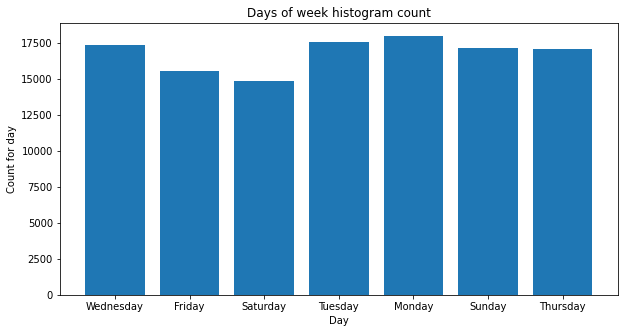

In [65]:
generate_days_histogram(nyt_train_df_2010[nyt_train_df_2010['year'] >= 2015])

In [66]:
print('Lets check nuber of enteries on eval df for crosswords newer than 2015',nyt_eval_df_2010[nyt_eval_df_2010['year'] >= 2015].shape)

Lets check nuber of enteries on eval df for crosswords newer than 2015 (33848, 5)


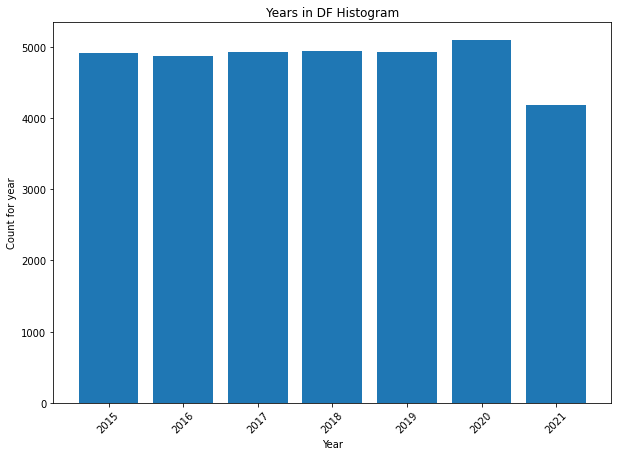

In [67]:
create_year_histogram(nyt_eval_df_2010[nyt_eval_df_2010['year'] >= 2015])

Sunday  Values is  4919  Which in proportion to other days is:  0.145
Monday  Values is  5187  Which in proportion to other days is:  0.153
Tuesday  Values is  5176  Which in proportion to other days is:  0.153
Wednesday  Values is  4973  Which in proportion to other days is:  0.147
Thursday  Values is  4986  Which in proportion to other days is:  0.147
Friday  Values is  4407  Which in proportion to other days is:  0.13
Saturday  Values is  4200  Which in proportion to other days is:  0.124


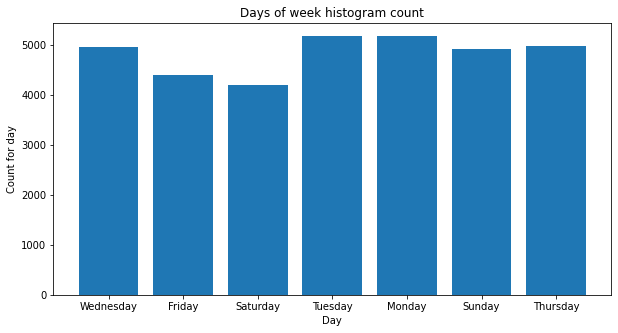

In [68]:
generate_days_histogram(nyt_eval_df_2010[nyt_eval_df_2010['year'] >= 2015])

In [69]:
print('Lets check nuber of enteries on eval df for crosswords newer than 2015',nyt_test_df_2010[nyt_test_df_2010['year'] >= 2015].shape)

Lets check nuber of enteries on eval df for crosswords newer than 2015 (16684, 5)


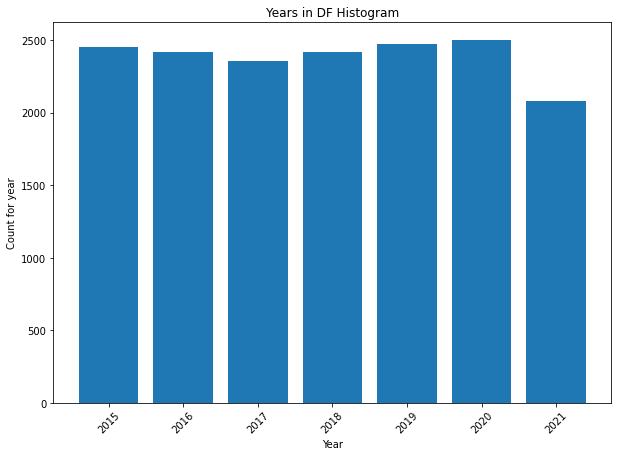

In [70]:
create_year_histogram(nyt_test_df_2010[nyt_test_df_2010['year'] >= 2015])

Sunday  Values is  2451  Which in proportion to other days is:  0.147
Monday  Values is  2548  Which in proportion to other days is:  0.153
Tuesday  Values is  2511  Which in proportion to other days is:  0.151
Wednesday  Values is  2437  Which in proportion to other days is:  0.146
Thursday  Values is  2491  Which in proportion to other days is:  0.149
Friday  Values is  2136  Which in proportion to other days is:  0.128
Saturday  Values is  2110  Which in proportion to other days is:  0.126


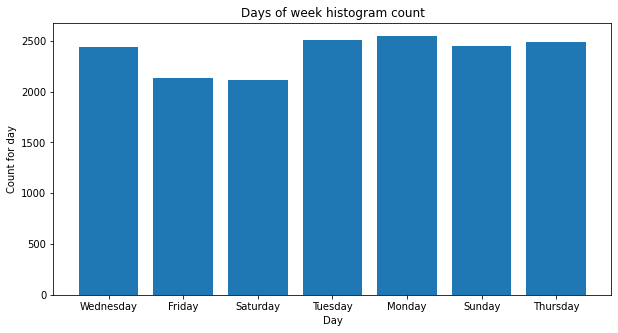

In [72]:
generate_days_histogram(nyt_test_df_2010[nyt_test_df_2010['year'] >= 2015])

In [73]:
nyt_train_df_2015 = nyt_train_df_2010[nyt_train_df_2010['year'] >= 2015]
nyt_eval_df_2015 = nyt_eval_df_2010[nyt_eval_df_2010['year'] >= 2015]
nyt_test_df_2015 = nyt_test_df_2010[nyt_test_df_2010['year'] >= 2015]

In [74]:
nyt_train_df_2015.to_csv('/content/drive/MyDrive/NLP/Project/nytcrosswords_balanced_days_train_2015.csv')
nyt_eval_df_2015.to_csv('/content/drive/MyDrive/NLP/Project/nytcrosswords_balanced_days_eval_2015.csv')
nyt_test_df_2015.to_csv('/content/drive/MyDrive/NLP/Project/nytcrosswords_balanced_days_test_2015.csv')